#Fashion-MNIST (MLP)

*Objetivo*

Construir y evaluar un **clasificador MLP** sobre **Fashion-MNIST** comparando **2 funciones de pérdida** (*categorical_crossentropy*, *mse*) y **2 optimizadores** (*adam*, *sgd*). Registrar curvas, métricas y una **conclusión** justificando la mejor combinación.

In [155]:
!pip install tensorflow

In [156]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

#Librerias

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Input


# =============================================================================
# ESTILOS VISUALES PARA LA TERMINAL (CLI)
# =============================================================================

class Colors:
    """
    Clase para guardar los códigos de escape ANSI para dar color a la salida en la terminal.
    """
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'      # Código para resetear el color
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def print_header(title):
    """Imprime un encabezado principal estilizado."""
    print(f"\n{Colors.BOLD}{Colors.HEADER}{'='*60}{Colors.ENDC}")
    print(f"{Colors.BOLD}{Colors.HEADER}📊 {title.upper()}{Colors.ENDC}")
    print(f"{Colors.BOLD}{Colors.HEADER}{'='*60}{Colors.ENDC}")

def print_subheader(title):
    """Imprime un subencabezado estilizado."""
    print(f"\n{Colors.BOLD}{Colors.OKCYAN}🔹 {title}{Colors.ENDC}")
    print(f"{Colors.OKCYAN}{'-'*40}{Colors.ENDC}")

def print_info(message):
    """Imprime un mensaje informativo."""
    print(f"{Colors.OKBLUE}ℹ️  {message}{Colors.ENDC}")

def print_success(message):
    """Imprime un mensaje de éxito."""
    print(f"{Colors.OKGREEN}✅ {message}{Colors.ENDC}")

def print_warning(message):
    """Imprime un mensaje de advertencia."""
    print(f"{Colors.WARNING}⚠️  {message}{Colors.ENDC}")

def print_error(message):
    """Imprime un mensaje de error."""
    print(f"{Colors.FAIL}❌ {message}{Colors.ENDC}")

def print_text(message):
    """Imprime un texto normal, sin color ni íconos."""
    print(message)

# =============================================================================
# ESTILOS PARA GRÁFICAS (MATPLOTLIB / SEABORN)
# =============================================================================

def get_plot_colors(n_colors=4):
    """
    Genera una paleta de colores profesional para usar en gráficas.

    Args:
        n_colors (int): El número de colores que necesitas.

    Returns:
        list: Una lista de códigos de color hexadecimales.
    """
    return sns.color_palette("flare", n_colors).as_hex()



env: TF_FORCE_GPU_ALLOW_GROWTH=true


**Dataset Fashion-MNIST**


🔹 Ejemplos de imágenes de Fashion-MNIST
----------------------------------------


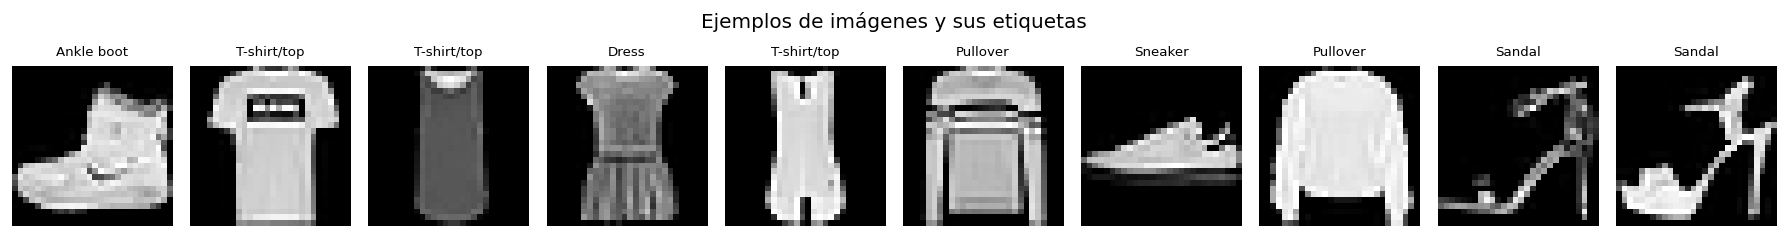

In [157]:
## Carga del dataset y analisis exploratorio

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#Definición de nombres
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Escala robusta: [0,1] o [0,255]
vmax = 1.0 if x_train.dtype != np.uint8 and x_train.max() <= 1.0 else 255.0

print_subheader("Ejemplos de imágenes de Fashion-MNIST")

fig, axes = plt.subplots(1, 10, figsize=(15, 2), dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap="gray", vmin=0, vmax=vmax)
    ax.set_title(class_names[y_train[i]], fontsize=8)
    ax.axis("off")
fig.suptitle("Ejemplos de imágenes y sus etiquetas", fontsize=12)
fig.tight_layout()
plt.show()


🔹 Distribución de clases
----------------------------------------


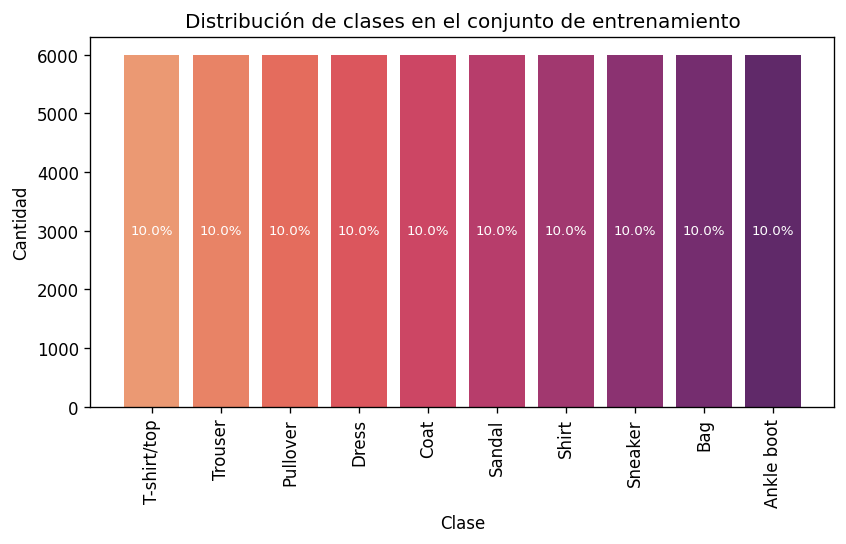

In [158]:
# Cálculo de distribución de clases

# Obtener las clases únicas y sus conteos en el conjunto de entrenamiento
unique, counts = np.unique(y_train, return_counts=True)
# Calcular el total de imágenes y los porcentajes por clase
total = int(counts.sum())
percent = counts/total

# Imprimir subencabezado
print_subheader("Distribución de clases")

# Crear la figura y los ejes para la gráfica
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
# Crear el gráfico de barras
bars = ax.bar(unique, counts, color=get_plot_colors(len(unique)))
# Configurar las etiquetas del eje x con los nombres de las clases y rotación
ax.set_xticks(unique)
ax.set_xticklabels(class_names, rotation=90)
# Configurar etiquetas de los ejes y título
ax.set_xlabel("Clase")
ax.set_ylabel("Cantidad")
ax.set_title("Distribución de clases en el conjunto de entrenamiento")

# Añadir etiquetas de porcentaje dentro de cada barra
for bar, p in zip(bars, percent):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height / 2, # Posición vertical ajustada al centro de la barra
            f'{p:.1%}',
            ha='center', va='center', color='white', fontsize=8) # Alinear al centro y color blanco para visibilidad

# Mostrar la gráfica
plt.show()

**Histograma de Intensidades**

Creación de histograma normalizado.
Se muestra mínimos, máximos, desviación estandar y media.

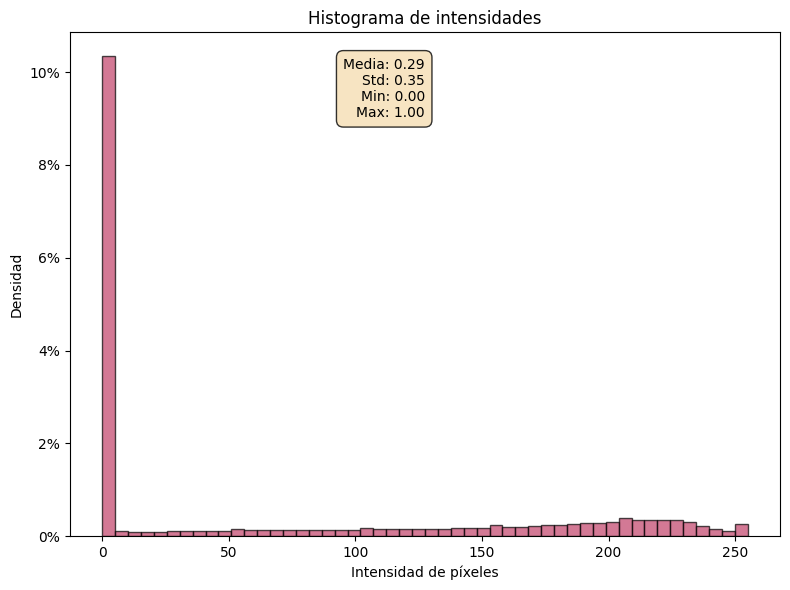

In [159]:
# Histograma de intensidades

fig, ax = plt.subplots(1, 1, figsize=(8,6)) # Crear una sola figura y ejes

# Histograma normalizado
n, bins, patches = ax.hist(x_train.ravel(), bins=50, density=True, alpha=0.7, label="Histograma", color=get_plot_colors(1)[0], edgecolor='black') # Usar el color de la paleta

# Resumen estadístico
vals = x_train.ravel()
stats_txt =(f"Media: {np.mean(vals):.2f}\nStd: {np.std(vals):.2f}\nMin: {np.min(vals):.2f}\nMax: {np.max(vals):.2f}")


ax.text(0.50, 0.95, f"Media: {mean:.2f}\nStd: {std:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}",
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))


ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) # Formatear el eje y para mostrar porcentajes
ax.set_title("Histograma de intensidades") # Título del gráfico
ax.set_xlabel("Intensidad de píxeles") # Etiqueta del eje x
ax.set_ylabel("Densidad") # Etiqueta del eje y


plt.tight_layout()
plt.show()

**Normalización de pixeles con valores 0 a 1**


In [160]:
# Normalización de los datos

# Convertir los datos de entrenamiento a float32 y normalizar dividiendo por 255.0
x_train = x_train.astype("float32")/255.0
# Convertir los datos de prueba a float32 y normalizar dividiendo por 255.0
x_test  = x_test.astype("float32")/255.0

# Imprimir un subencabezado para la sección de Normalización
print_subheader("Normalización")

# Crear un DataFrame para mostrar información resumida de los datos normalizados
df_normalizacion = pd.DataFrame({
    'dataset': ['x_train', 'x_test'], # Nombres de los conjuntos de datos
    'min': [x_train.min(), x_test.min()], # Valor mínimo de píxeles
    'max': [x_train.max(), x_test.max()], # Valor máximo de píxeles
    'dtype': [x_train.dtype, x_test.dtype], # Tipo de datos
    'shape': [x_train.shape, x_test.shape], # Forma de los arreglos
})

# Mostrar el DataFrame con la información de normalización
display(df_normalizacion)


🔹 Normalización
----------------------------------------


,dataset,min,max,dtype,shape
0,x_train,0.0,1.0,float32,"(60000, 28, 28)"
1,x_test,0.0,1.0,float32,"(10000, 28, 28)"


In [161]:
#Configuración de semilla
SEED = 42
tf.keras.utils.set_random_seed(SEED)
print_subheader("Configuración de la semilla")
print("TensorFlow:", tf.__version__)


🔹 Configuración de la semilla
----------------------------------------
TensorFlow: 2.19.0


**One-hot encoding**

In [162]:
# One-hot encoding

# Definir el número de clases
num_classes = 10

# Convertir las etiquetas de entrenamiento a formato one-hot encoding
y_train_oh = to_categorical(y_train, num_classes)
# Convertir las etiquetas de prueba a formato one-hot encoding
y_test_oh  = to_categorical(y_test, num_classes)

print_subheader("One-hot encoding")
df_onehot = pd.DataFrame({
    'dataset': ['y_train', 'y_test'],
    'shapes': [y_train_oh.shape, y_test_oh.shape],
    'n_classes': [num_classes, num_classes],
    'dtype': [y_train_oh.dtype, y_test_oh.dtype],


})
display(df_onehot)



🔹 One-hot encoding
----------------------------------------


,dataset,shapes,n_classes,dtype
0,y_train,"(60000, 10)",10,float64
1,y_test,"(10000, 10)",10,float64


**Diseño del modelo y parámetros**

Definimos el modelo, Configuramos parámetros de entrenamiento, curvas de perdida y precision y evaluación detallada del mejor modelo.


In [163]:
#Definición del modelo (MLP)

def build_mlp(input_shape=(28,28), act1="relu", act2="tanh"):
    model = models.Sequential([
        Input(shape=input_shape),
        layers.Flatten(name="flatten"),
        layers.Dense(256, activation=act1, name="dense_1"),
        layers.Dense(128, activation=act2, name="dense_2"),
        layers.Dense(10, activation="softmax", name="output")
    ])
    return model

print_subheader("Definición del modelo")

model = build_mlp()
model.summary()


🔹 Definición del modelo
----------------------------------------


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
# Entrenamiento (2 pérdidas × 2 optimizadores)

# Definir los experimentos con diferentes funciones de pérdida y optimizadores
experimentos = [
    {"loss":"categorical_crossentropy", "optimizer":"adam"},
    {"loss":"categorical_crossentropy", "optimizer":"sgd"},
    {"loss":"mse", "optimizer":"adam"},
    {"loss":"mse", "optimizer":"sgd"},
]

# Diccionarios para almacenar los historiales de entrenamiento y resultados
histories = {}
results = []

# Definir parámetros de entrenamiento
EPOCHS = 8
BATCH = 128
VAL_SPLIT = 0.2

# Iterar a través de cada experimento
for exp in experimentos:
    key = f"{exp['loss']}|{exp['optimizer']}"
    # Construir un nuevo modelo para cada experimento
    model = build_mlp()
    # Compilar el modelo con el optimizador y la función de pérdida especificados
    model.compile(optimizer=exp["optimizer"], loss=exp["loss"], metrics=["accuracy"])
    print_subheader(f"Experimento: {key}")
    # Entrenar el modelo
    h = model.fit(
        x_train, y_train_oh,
        validation_split=VAL_SPLIT,
        epochs=EPOCHS, batch_size=BATCH, verbose=2
    )
    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_acc = model.evaluate(x_test, y_test_oh, verbose=0)
    # Almacenar el historial de entrenamiento y los resultados de la prueba
    histories[key] = (h.history, test_loss, test_acc)

    # Obtener la mejor precisión de validación del historial de entrenamiento
    best_val_acc = float(np.max(h.history["val_accuracy"]))
    # Añadir los resultados a la lista de resultados
    results.append({
        "loss": exp["loss"],
        "optimizer": exp["optimizer"],
        "best_val_acc": best_val_acc,
        "final_val_acc": float(h.history["val_accuracy"][-1]),
        "test_acc": float(test_acc),
        "final_val_loss": float(h.history["val_loss"][-1]),
        "test_loss": float(test_loss),
    })




🔹 Experimento: categorical_crossentropy|adam
----------------------------------------
Epoch 1/8
375/375 - 9s - 25ms/step - accuracy: 0.8185 - loss: 0.5020 - val_accuracy: 0.8529 - val_loss: 0.4101
Epoch 2/8
375/375 - 5s - 14ms/step - accuracy: 0.8670 - loss: 0.3621 - val_accuracy: 0.8666 - val_loss: 0.3684
Epoch 3/8
375/375 - 6s - 17ms/step - accuracy: 0.8811 - loss: 0.3219 - val_accuracy: 0.8733 - val_loss: 0.3470
Epoch 4/8
375/375 - 10s - 26ms/step - accuracy: 0.8904 - loss: 0.2972 - val_accuracy: 0.8758 - val_loss: 0.3328
Epoch 5/8
375/375 - 5s - 13ms/step - accuracy: 0.8964 - loss: 0.2785 - val_accuracy: 0.8775 - val_loss: 0.3275
Epoch 6/8
375/375 - 4s - 10ms/step - accuracy: 0.9026 - loss: 0.2633 - val_accuracy: 0.8777 - val_loss: 0.3243
Epoch 7/8
375/375 - 6s - 17ms/step - accuracy: 0.9073 - loss: 0.2484 - val_accuracy: 0.8785 - val_loss: 0.3245
Epoch 8/8
375/375 - 3s - 8ms/step - accuracy: 0.9134 - loss: 0.2338 - val_accuracy: 0.8757 - val_loss: 0.3322

🔹 Experimento: categoric

In [165]:
# Crear un DataFrame a partir de los resultados y ordenarlo
df_results = pd.DataFrame(results).sort_values(["test_acc","best_val_acc"], ascending=False)
# Restablecer el índice del DataFrame
df_results.reset_index(drop=True, inplace=True)
# Mostrar el DataFrame de resultados
df_results

,loss,optimizer,best_val_acc,final_val_acc,test_acc,final_val_loss,test_loss
0,categorical_crossentropy,adam,0.878500,0.875667,0.8732,0.332155,0.358122
1,mse,adam,0.883500,0.876250,0.8690,0.018020,0.019161
2,categorical_crossentropy,sgd,0.841417,0.841417,0.8347,0.450890,0.475219
3,mse,sgd,0.663917,0.663917,0.6532,0.051210,0.051902


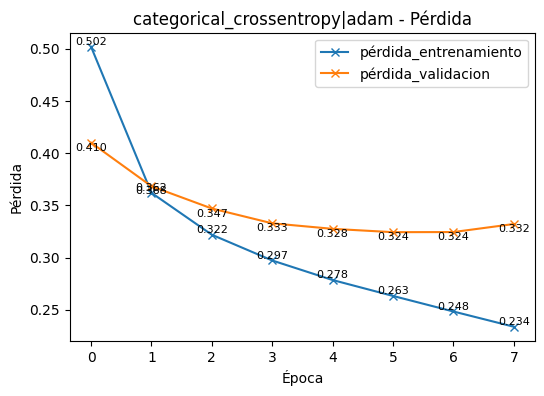

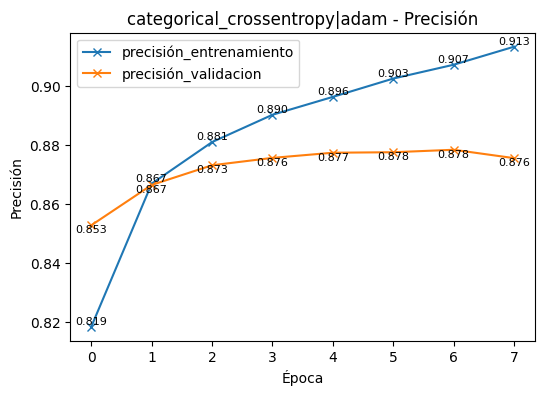

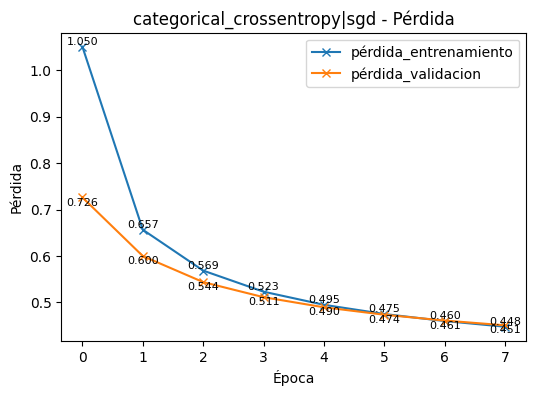

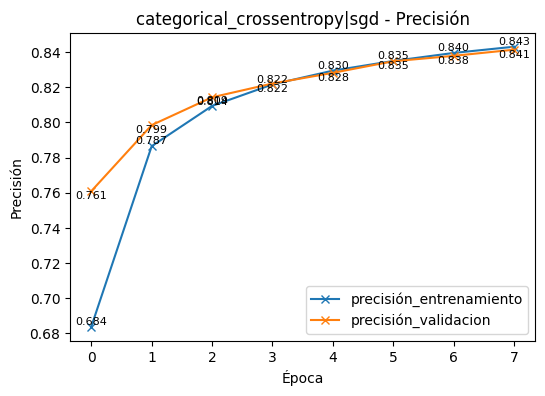

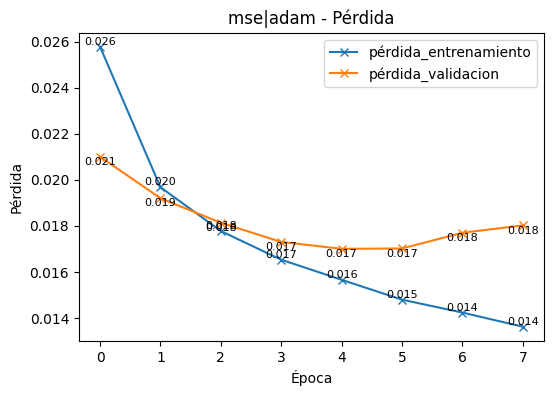

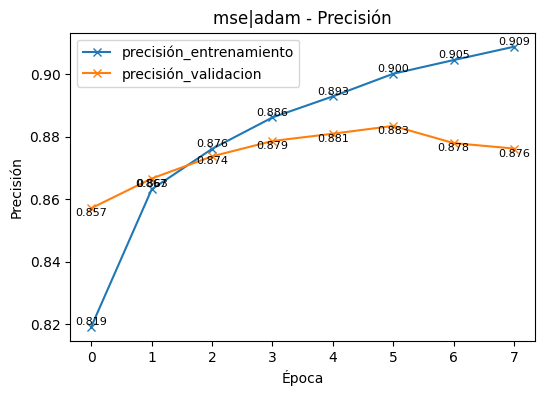

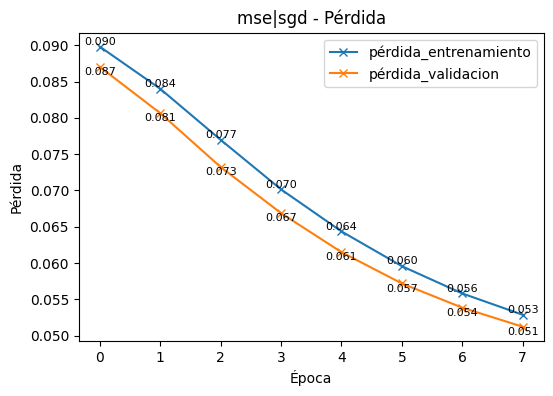

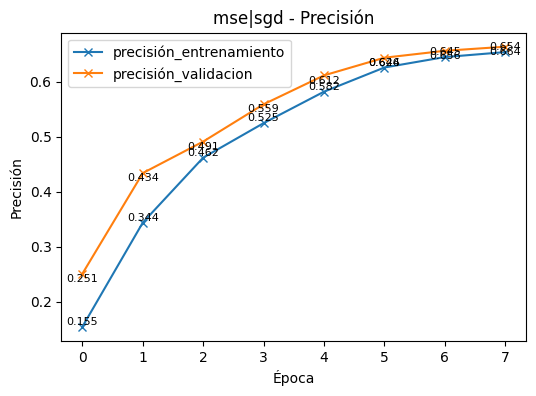

In [175]:
# Curvas de pérdida y precisión

def plot_history(hist, title_prefix=""):
    """
    Grafica las curvas de pérdida y precisión de entrenamiento y validación.

    Args:
        hist (dict): Un diccionario que contiene el historial de entrenamiento (pérdida y precisión).
        title_prefix (str): Un prefijo para los títulos de las gráficas.
    """
    plt.figure(figsize=(6,4))
    plt.plot(hist["loss"], label="pérdida_entrenamiento", marker='x')
    plt.plot(hist["val_loss"], label="pérdida_validacion", marker='x')
    plt.title(f"{title_prefix} - Pérdida")
    plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.legend();

    # Agregar valores de pérdida en cada época
    for i, (train_loss, val_loss) in enumerate(zip(hist["loss"], hist["val_loss"])):
        plt.text(i, train_loss, f'{train_loss:.3f}', ha='center', va='bottom', fontsize=8)
        plt.text(i, val_loss, f'{val_loss:.3f}', ha='center', va='top', fontsize=8)


    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["accuracy"], label="precisión_entrenamiento", marker='x')
    plt.plot(hist["val_accuracy"], label="precisión_validacion", marker='x')
    plt.title(f"{title_prefix} - Precisión")
    plt.xlabel("Época"); plt.ylabel("Precisión"); plt.legend();

    # Agregar valores de precisión en cada época
    for i, (train_acc, val_acc) in enumerate(zip(hist["accuracy"], hist["val_accuracy"])):
        plt.text(i, train_acc, f'{train_acc:.3f}', ha='center', va='bottom', fontsize=8)
        plt.text(i, val_acc, f'{val_acc:.3f}', ha='center', va='top', fontsize=8)

    plt.show()

# Graficar el historial para cada experimento
for key, (hist, tl, ta) in histories.items():
    plot_history(hist, key)

Mejor experimento: categorical_crossentropy|adam
Precisión en prueba (reentrenado): 0.8734

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9132    0.6940    0.7886      1000
           1     0.9928    0.9620    0.9771      1000
           2     0.8124    0.7750    0.7932      1000
           3     0.8984    0.8750    0.8865      1000
           4     0.8128    0.7770    0.7945      1000
           5     0.9528    0.9700    0.9613      1000
           6     0.5930    0.8130    0.6858      1000
           7     0.9368    0.9490    0.9429      1000
           8     0.9625    0.9760    0.9692      1000
           9     0.9712    0.9430    0.9569      1000

    accuracy                         0.8734     10000
   macro avg     0.8846    0.8734    0.8756     10000
weighted avg     0.8846    0.8734    0.8756     10000



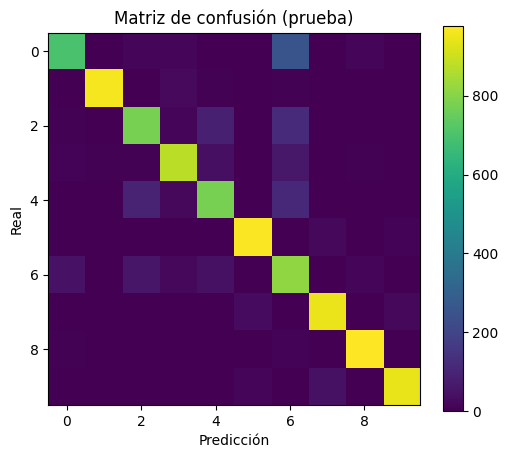

In [177]:
# Evaluación detallada del mejor modelo

# Obtener los detalles del mejor experimento a partir del DataFrame de resultados
best_key = df_results.iloc[0]
best_id = f"{best_key['loss']}|{best_key['optimizer']}"
print("Mejor experimento:", best_id)

# Construir y compilar un nuevo modelo utilizando los parámetros del mejor experimento
model_best = build_mlp()
model_best.compile(optimizer=str(best_key['optimizer']), loss=str(best_key['loss']), metrics=["accuracy"])
# Entrenar el mejor modelo en todos los datos de entrenamiento (excluyendo la división de validación para esta evaluación final)
# verbose=0 suprime la salida del entrenamiento
_ = model_best.fit(x_train, y_train_oh, validation_split=0.2, epochs=8, batch_size=128, verbose=0)

# Hacer predicciones sobre el conjunto de prueba y obtener las etiquetas de clase predichas
pred_test = model_best.predict(x_test, verbose=0).argmax(axis=1)
# Calcular e imprimir la precisión en prueba
print("Precisión en prueba (reentrenado):", (pred_test == y_test).mean())

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred_test, digits=4))

# Generar y mostrar la matriz de confusión
cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión (prueba)")
plt.colorbar(); plt.xlabel("Predicción"); plt.ylabel("Real"); plt.show()

**Conclusion**

In [168]:
# Conclusión y reflexión

print_subheader("=== CONCLUSIÓN ===")
# Obtener los detalles del mejor experimento
top = df_results.iloc[0]
# Imprimir la mejor combinación y sus métricas de rendimiento
print(f"Mejor combinación -> pérdida={top['loss']}, optimizador={top['optimizer']} | precision_prueba={top['test_acc']:.4f} | mejor_precision_validacion={top['best_val_acc']:.4f}")

print_subheader("\nReflexión:")
# Proporcionar una reflexión sobre los resultados y posibles mejoras futuras
print("* Con **softmax** para 10 clases, **categorical_crossentropy** suele optimizar mejor que **mse**, porque ajusta distribuciones de probabilidad.")
print("* **Adam** converge más rápido que **SGD** sin afinado de LR en pocas épocas.")
print("* ReLU+Tanh aporta no linealidad suficiente; con más tiempo, probar Dropout/BatchNorm y LR schedule.")

=== CONCLUSIÓN ===
Mejor combinación -> pérdida=categorical_crossentropy, optimizador=adam | precision_prueba=0.8732 | mejor_precision_validacion=0.8785

Reflexión:
* Con **softmax** para 10 clases, **categorical_crossentropy** suele optimizar mejor que **mse**, porque ajusta distribuciones de probabilidad.
* **Adam** converge más rápido que **SGD** sin afinado de LR en pocas épocas.
* ReLU+Tanh aporta no linealidad suficiente; con más tiempo, probar Dropout/BatchNorm y LR schedule.


# README: Clasificador MLP en Fashion-MNIST

**Objetivo:**

Este cuadernillo tiene como objetivo construir y evaluar un clasificador Multi-Layer Perceptron (MLP) sobre el conjunto de datos Fashion-MNIST, comparando el rendimiento de diferentes combinaciones de funciones de pérdida (categorical_crossentropy, mse) y optimizadores (adam, sgd). Se registran curvas de entrenamiento, métricas de evaluación y se presenta una conclusión para justificar la mejor combinación.

**Estructura:**


   **Carga y exploración del dataset:**
    *   Se carga el dataset Fashion-MNIST utilizando `tf.keras.datasets.fashion_mnist.load_data()`.
    *   Se incluye un análisis exploratorio para visualizar ejemplos de imágenes y la distribución de clases.

   **Preprocesamiento de datos:**
    *   Se preparan los datos para el entrenamiento.
    *   Se normalizan los valores de los píxeles a un rango de 0 a 1 dividiendo por 255.0.
    *   Se aplica One-hot encoding a las etiquetas utilizando `tf.keras.utils.to_categorical` para convertirlas en un formato binario adecuado para la clasificación multiclase.

   **Definición y diseño del modelo MLP:**
    *   Se define la arquitectura del clasificador MLP utilizando la API Sequential de Keras.
    *   Se especifica la estructura de las capas densas y las funciones de activación ('relu' y 'tanh') utilizadas en las capas ocultas, así como la capa de salida con activación 'softmax'.

   **Entrenamiento de modelos con diferentes configuraciones:**
    *   Se configura y ejecuta el entrenamiento de múltiples modelos MLP.
    *   Se prueban diferentes combinaciones de funciones de pérdida ('categorical_crossentropy', 'mse') y optimizadores ('adam', 'sgd') para evaluar su rendimiento.
    *   Los modelos se compilan y entrenan durante un número fijo de épocas y tamaño de lote.

   **Evaluación de modelos:**
    *   Se generan y visualizan curvas de pérdida y precisión para el entrenamiento y la validación a lo largo de las épocas.
    *   También se presenta un resumen tabular de los resultados clave (precisión en validación y prueba) para cada experimento.

   **Evaluación detallada del mejor modelo:**
    *   Se identifica el modelo con el mejor rendimiento basado en la evaluación previa y se realiza una evaluación más detallada en el conjunto de prueba.
    *   Esto incluye calcular la precisión general, generar un reporte de clasificación con métricas por clase (precisión, exhaustividad/recall, f1-score) y visualizar estas métricas en un gráfico.

   **Conclusión y reflexión:**
    *   Se presenta una conclusión que resume los hallazgos de los experimentos.
    *   Se justifica la mejor combinación de función de pérdida y optimizador basándose en las métricas de rendimiento.
    *   Se incluye una reflexión sobre el proceso y posibles mejoras futuras.

**Librerías Utilizadas:**

*   **tensorflow:** Utilizada para construir, entrenar y evaluar el modelo MLP, cargar el conjunto de datos Fashion-MNIST y realizar la codificación one-hot.
*   **numpy:** Utilizada para operaciones numéricas, manipulación de arreglos (por ejemplo, calcular la media, desviación estándar, mínimo, máximo de las intensidades de píxeles) y trabajar con los arreglos del dataset.
*   **matplotlib.pyplot:** Utilizada para crear varias gráficas, incluyendo ejemplos de imágenes, distribución de clases, histograma de intensidades, curvas de historial de entrenamiento (pérdida y precisión) y gráficos de métricas por clase.
*   **seaborn:** Utilizada para mejorar la estética de las gráficas de matplotlib y potencialmente para crear visualizaciones estadísticas (por ejemplo, usando sus paletas de colores).
*   **pandas:** Utilizada para crear y mostrar DataFrames para resumir información de los datos (detalles de normalización, detalles de codificación one-hot y resultados del entrenamiento).
*   **sklearn.metrics:** Utilizada para evaluar el rendimiento del modelo en el conjunto de prueba, específicamente para generar el reporte de clasificación y la matriz de confusión (aunque reemplazada por una gráfica de métricas por clase en la versión actual).
